In [5]:
import math
import scipy.stats as stats
# 填入 X-->M 的結果
A7 = 0.598 # 迴歸係數
B7 = 0.145 # 標準誤
C7 = 0.487 # 標準化迴歸係數
# 填入 M-->Y 的結果
D7 = 0.503 # 迴歸係數
E7 = 0.103 # 標準誤
F7 = 0.558 # 標準化迴歸係數


# 計算結果
SE = math.sqrt(A7*A7*E7*E7+D7*D7*B7*B7)
d = C7*F7 # 效果量d
Sobel = A7*D7/SE # Sobel's z
cdf_value = stats.norm.cdf(abs(Sobel))
p = 2*(1-cdf_value) # 顯著性（p<=0.5表示有中介效果）
ans = "無中介效果" if p > 0.05 else "有中介效果"
print("效果量(d)",round(d, 2))
print("Sobel's z",round(Sobel, 2))
print("顯著性",round(p, 3), ans)

效果量(d) 0.27
Sobel's z 3.15
顯著性 0.002 有中介效果


# Computer Vision Masterclass - Autoencoders for image compression

![](https://edit.wpgdadawant.com/uploads/news_file/blog/2023/10230/tinymce/autoencoder.png)

![upgit_20240519_1716057798.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240519_1716057798.png)

AutoEncoder架構分成兩大部分：編碼器（Encoder）和解碼器（Decoder）。

編碼器（Encoder）：編碼器將輸入數據轉換為較低維度的表示。

解碼器（Decoder）：解碼器則將編碼的表示轉換回原始輸入數據。

AutoEncoder應用：
- 圖片降噪
- 圖片壓縮
- 欺詐檢測
- 降維

AutoEncoder優點
- 數據的降維，減少計算量和存儲空間。
- 數據的去噪，通過重建輸入來恢復原始信號。
- 數據的生成，通過採樣隱藏表示來產生新的數據。
- 數據的特徵學習，通過提取隱藏表示來獲得數據的抽象特徵。

AutoEncoder缺點
- 可能會過度壓縮數據，導致信息的丟失或失真。
- 可能會過度擬合數據，導致泛化能力差或無法處理異常值。
- 可能會難以訓練，尤其是當隱藏層很深或很寬時，需要調整多個超參數和正則化項。
- 可能會難以解釋，尤其是當隱藏表示是非線性或高度非結構化時，需要使用可視化或其他方法來理解其含義。

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
tf.__version__

'2.15.0'

## 載入資料集

- Dataset: https://keras.io/api/datasets/mnist/

In [57]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [58]:
y_train[0], X_train[0]

(5,
 array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
        

## 視覺化圖案

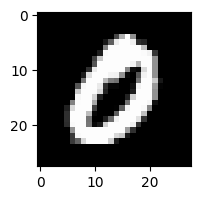

In [59]:
# 輸出一張
i = np.random.randint(0, 59999)
plt.figure(figsize=(4, 2))
plt.imshow(X_train[i], cmap='gray')

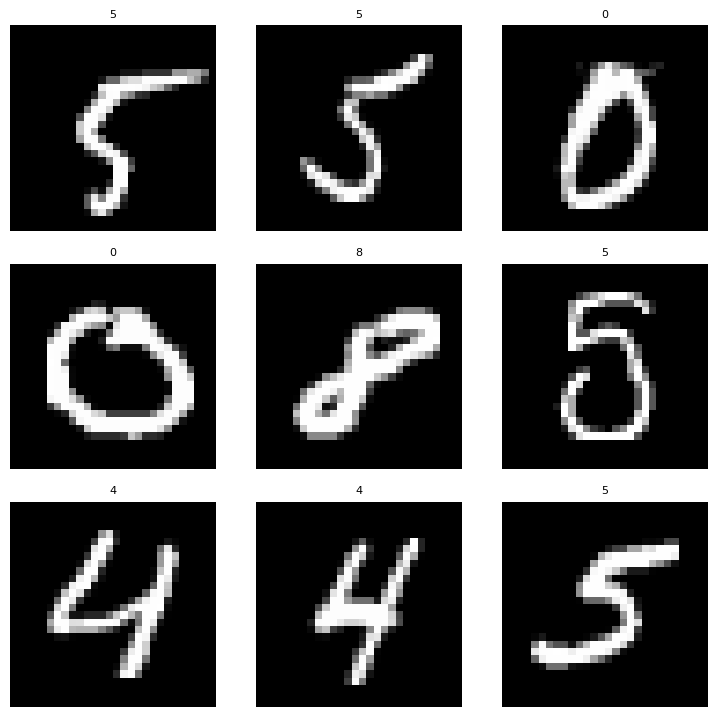

In [60]:
# 輸出九張
width = 3
height = 3
fig, axes = plt.subplots(height, width, figsize=(9, 9))
#print(axes.shape)
axes = axes.ravel() # -> (10,10) -> [100]
#print(axes.shape)
for i in np.arange(0, width * height):
  index = np.random.randint(0, 59999)
  # plt.figure(figsize=(4, 2))
  axes[i].imshow(X_train[index], cmap = 'gray')
  axes[i].set_title(y_train[index], fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.1)

## 預處理圖片

In [61]:
print(X_train[0].min(), X_train[0].max())
X_train = X_train / 255
X_test = X_test / 255
print(X_train[0].min(), X_train[0].max())

0 255
0.0 1.0


In [62]:
print(X_train.shape, X_test.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


## 建立線性編碼器

In [63]:
# 784 - 128 - 64 - 32 - 64 - 128 - 784
autoencoder = Sequential()

# Encode
autoencoder.add(Dense(units = 128, activation='relu', input_dim = 784))
autoencoder.add(Dense(units = 64, activation='relu'))
autoencoder.add(Dense(units = 32, activation='relu')) # Encoded image

# Decode
autoencoder.add(Dense(units = 64, activation='relu'))
autoencoder.add(Dense(units = 128, activation='relu'))
autoencoder.add(Dense(units = 784, activation='sigmoid'))

autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 784)               101136    
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 222

In [64]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])
autoencoder.fit(X_train, X_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1522 - accuracy: 0.0106
Epoch 2/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1083 - accuracy: 0.0111
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1003 - accuracy: 0.0126
Epoch 4/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0957 - accuracy: 0.0135
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0929 - accuracy: 0.0127
Epoch 6/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0907 - accuracy: 0.0126
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0890 - accuracy: 0.0136
Epoch 8/50
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0876 - accuracy: 0.0136
Epoch 9/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0866 - accuracy: 0.0139
Epoch 10/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.08

## 對圖片進行編碼

查看所有層數

In [65]:
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 784)               101136    
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 222

In [67]:
 # 檢查他的第一層
print("模型起點", autoencoder.input)

# 指定到中間那一層
print(autoencoder.get_layer('dense_20').output)

模型起點 KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='dense_18_input'), name='dense_18_input', description="created by layer 'dense_18_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='dense_20/Relu:0', description="created by layer 'dense_20'")


In [68]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('dense_20').output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18_input (InputLayer  [(None, 784)]             0         
 )                                                               
                                                                 
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
Total params: 110816 (432.88 KB)
Trainable params: 110816 (432.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


使用圖片來做測試

(784,)


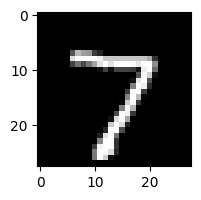

In [70]:
print(X_test[0].shape)
plt.figure(figsize=(4, 2))
plt.imshow(X_test[0].reshape(28,28), cmap='gray');

In [71]:
X_test[0].reshape(-1, 784).shape

(1, 784)

In [72]:
encoded_image = encoder.predict(X_test[0].reshape(1,-1))

1/1 [==============================] - 0s 49ms/step


資料大小 (1, 32)


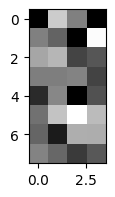

In [75]:
print("資料大小", encoded_image.shape)
encoded_image,
plt.figure(figsize=(4, 2))
plt.imshow(encoded_image.reshape(8,4), cmap='gray');



## 對圖片進行解碼


In [76]:
autoencoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               100480    
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 784)               101136    
                                                                 
Total params: 222384 (868.69 KB)
Trainable params: 222

In [77]:
input_layer_decoder = Input(shape=(32,))
decoder_layer1 = autoencoder.layers[3]
decoder_layer2 = autoencoder.layers[4]
decoder_layer3 = autoencoder.layers[5]
decoder = Model(inputs = input_layer_decoder, outputs = decoder_layer3(decoder_layer2(decoder_layer1(input_layer_decoder))))
decoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dense_23 (Dense)            (None, 784)               101136    
                                                                 
Total params: 111568 (435.81 KB)
Trainable params: 111568 (435.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
print(encoded_image.shape)
decoded_image = decoder.predict(encoded_image)
print(decoded_image.shape)

(1, 32)
1/1 [==============================] - 0s 47ms/step
(1, 784)


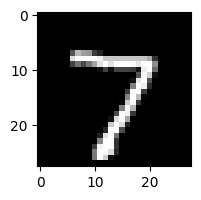

In [79]:
plt.figure(figsize=(4, 2))
plt.imshow(X_test[0].reshape(28,28), cmap = 'gray');

## 將 test images 進行編碼解碼


In [80]:
X_test.shape[0] # 9999

10000

1/1 [==============================] - 0s 17ms/step


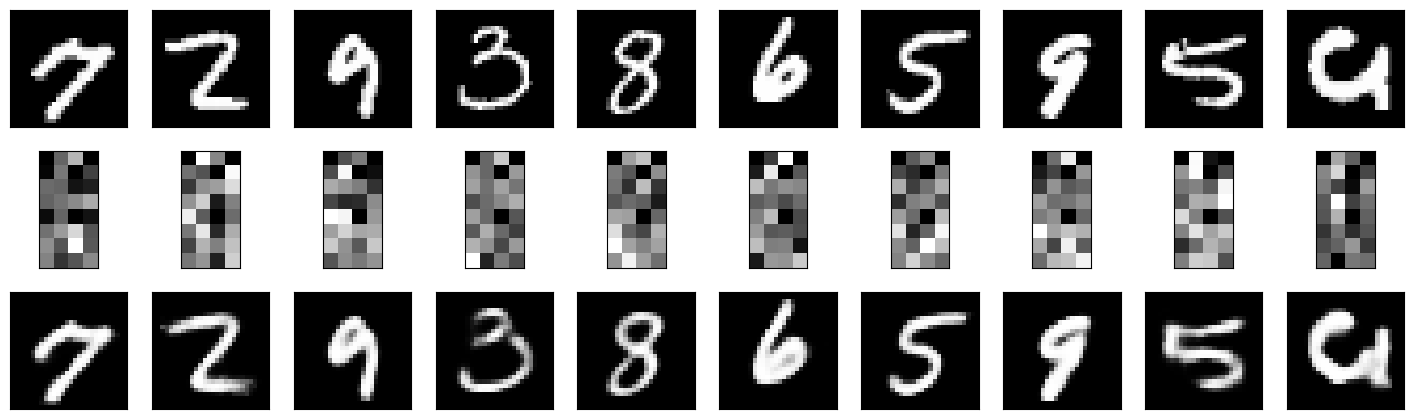

In [87]:
# 隨機挑十筆資料
n_images = 10
test_images = np.random.randint(0, X_test.shape[0] - 1, size = n_images)
# print(test_images)

plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # print(i, image_index)

  # Original image
  ax = plt.subplot(10,10,i + 1)
  plt.imshow(X_test[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Coded images
  ax = plt.subplot(10,10,i + 1 + n_images)
  encoded_image = encoder.predict(X_test[image_index].reshape(1,-1))
  plt.imshow(encoded_image.reshape(8,4), cmap = 'gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded images
  ax = plt.subplot(10,10,i + 1 + n_images * 2)
  plt.imshow(decoder.predict(encoded_image).reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

## 卷積自動編碼器

In [88]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Flatten

- Dataset: https://keras.io/api/datasets/fashion_mnist/

In [90]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [91]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## 顯示圖片

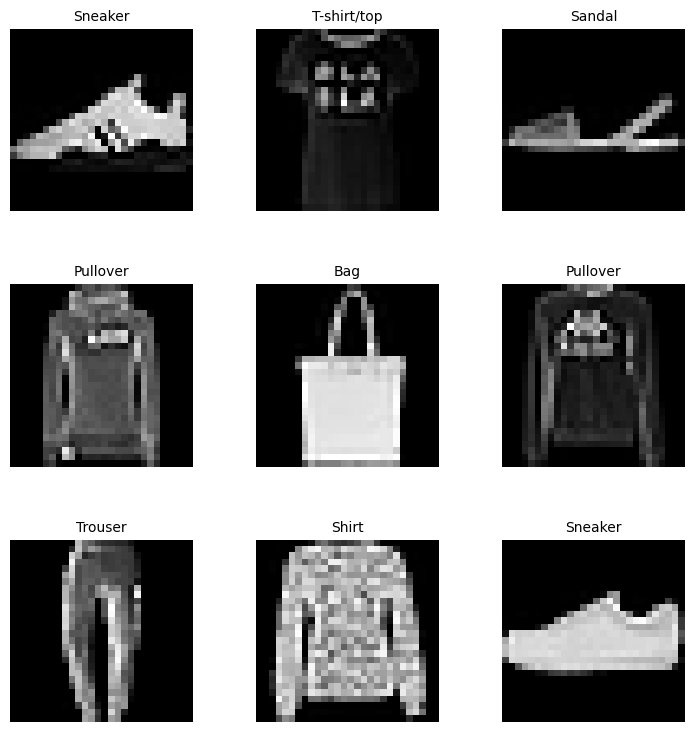

In [93]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
width = 3
height = 3

fig, axes = plt.subplots(height, width, figsize = (9,9))
axes = axes.ravel()
for i in np.arange(0, width * height):
    index = np.random.randint(0, 60000) # 資料總共6000比
    axes[i].imshow(X_train[index], cmap = 'gray' )
    axes[i].set_title(classes[y_train[index]], fontsize = 10)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

## 預處理圖片

In [94]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [95]:
X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

In [96]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [97]:
X_train.shape, X_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## 建立卷積自動編碼器

![upgit_20240509_1715249836.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240509_1715249836.png)

In [99]:
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow

autoencoder = Sequential()

# Encoder
autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu', padding='valid', input_shape=(28,28,1)))
autoencoder.add(MaxPooling2D(pool_size=(2,2)))

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#autoencoder.summary()

autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding = 'same', strides=(2,2)))

autoencoder.add(Flatten())

#autoencoder.summary()

# Decoder

autoencoder.add(Reshape((4,4,8)))
#autoencoder.summary()
autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
#autoencoder.summary()
autoencoder.add(UpSampling2D(size=(2,2)))
#autoencoder.summary()

autoencoder.add(Conv2D(filters = 8, kernel_size=(3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 16, kernel_size=(3,3), activation='relu'))
autoencoder.add(UpSampling2D(size=(2,2)))

autoencoder.add(Conv2D(filters = 1, kernel_size=(3,3), activation='sigmoid', padding='same'))


autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 flatten_2 (Flatten)         (None, 128)              

In [100]:
autoencoder.compile(optimizer='Adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [101]:
autoencoder.fit(X_train, X_train, epochs = 50)

Epoch 1/50
1875/1875 [==============================] - 13s 5ms/step - loss: 0.3162 - accuracy: 0.5039
Epoch 2/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2913 - accuracy: 0.5063
Epoch 3/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2859 - accuracy: 0.5070
Epoch 4/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2828 - accuracy: 0.5073
Epoch 5/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2806 - accuracy: 0.5075
Epoch 6/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2790 - accuracy: 0.5077
Epoch 7/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2778 - accuracy: 0.5078
Epoch 8/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2770 - accuracy: 0.5079
Epoch 9/50
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2762 - accuracy: 0.5080
Epoch 10/50
1875/1875 [==============================] - 10s 5ms/step - l

### Encoding and decoding the test images

In [102]:
autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 flatten_2 (Flatten)         (None, 128)              

In [103]:
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.get_layer('flatten_2').output)
encoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14_input (InputLaye  [(None, 28, 28, 1)]       0         
 r)                                                              
                                                                 
 conv2d_14 (Conv2D)          (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 13, 13, 8)         1160      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                           

In [104]:
coded_test_images = encoder.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [105]:
coded_test_images.shape

(10000, 128)

In [106]:
coded_test_images[0]

array([0.11483102, 0.5927415 , 0.26034877, 0.53287435, 0.09484479,
       0.5304644 , 0.9765902 , 1.3089873 , 0.07920279, 0.60014194,
       0.22375152, 0.6914531 , 0.35394388, 0.5492594 , 1.171058  ,
       1.53429   , 0.        , 0.7257332 , 0.10741121, 0.8288149 ,
       0.31694025, 0.7055757 , 0.9857019 , 1.7700232 , 0.07655373,
       0.35632402, 0.28523767, 0.71604323, 0.3012914 , 0.6824075 ,
       0.98818165, 1.1571497 , 0.02786526, 0.5727103 , 0.48126328,
       0.3456759 , 0.25156975, 0.48308638, 0.7414614 , 1.5505575 ,
       0.6893038 , 0.9176727 , 0.613943  , 0.50242424, 0.5940612 ,
       0.38483828, 1.7524621 , 1.5304617 , 2.2659838 , 2.3387668 ,
       1.3309964 , 0.56139785, 0.7642948 , 1.0241735 , 1.7114079 ,
       0.8447039 , 1.1696641 , 2.2478435 , 0.8768753 , 0.68803114,
       0.4664765 , 1.904175  , 0.687417  , 1.1902093 , 1.9431751 ,
       1.4466431 , 1.142437  , 0.3991813 , 0.09028673, 0.5589638 ,
       1.2178779 , 0.9449067 , 2.1125638 , 1.9734893 , 1.44261

In [107]:
decoded_test_images = autoencoder.predict(X_test)
decoded_test_images.shape

313/313 [==============================] - 1s 4ms/step


(10000, 28, 28, 1)

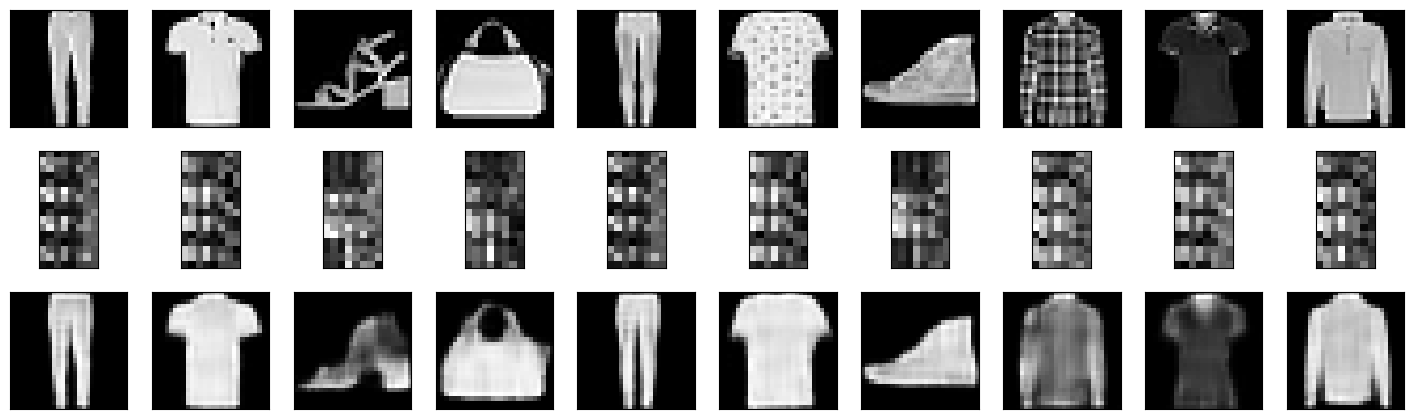

In [108]:
n_images = 10
test_images = np.random.randint(0, X_test.shape[0], size = n_images)
plt.figure(figsize=(18,18))
for i, image_index in enumerate(test_images):
  # Original images
  ax = plt.subplot(10,10, i + 1)
  plt.imshow(X_test[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Coded images
  ax = plt.subplot(10,10, i + 1 + n_images)
  plt.imshow(coded_test_images[image_index].reshape(16,8), cmap='gray')
  plt.xticks(())
  plt.yticks(())

  # Decoded images
  ax = plt.subplot(10,10, i + 1 + n_images * 2)
  plt.imshow(decoded_test_images[image_index].reshape(28,28), cmap='gray')
  plt.xticks(())
  plt.yticks(())